In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn

In [2]:
n = 1_000_000
p = 0.5
μ_1, μ_2, μ_3 = 0.2, 0.8, 0.4
σ_1, σ_2, σ_3 = 0.1, 0.05, 0.2

In [3]:
%%time

S = 0.0
for i in range(n):
    X_1 = np.exp(μ_1 + σ_1 * randn())
    X_2 = np.exp(μ_2 + σ_2 * randn())
    X_3 = np.exp(μ_3 + σ_3 * randn())
    S += (X_1 + X_2 + X_3)**p
S / n

CPU times: user 1.76 s, sys: 7.72 ms, total: 1.77 s
Wall time: 1.69 s


2.229699438974815

In [4]:
def compute_mean(n=1_000_000):
    S = 0.0
    for i in range(n):
        X_1 = np.exp(μ_1 + σ_1 * randn())
        X_2 = np.exp(μ_2 + σ_2 * randn())
        X_3 = np.exp(μ_3 + σ_3 * randn())
        S += (X_1 + X_2 + X_3)**p
    return (S / n)

In [5]:
compute_mean()

2.2297895784779924

In [6]:
def compute_mean_vectorized(n=1_000_000):
    X_1 = np.exp(μ_1 + σ_1 * randn(n))
    X_2 = np.exp(μ_2 + σ_2 * randn(n))
    X_3 = np.exp(μ_3 + σ_3 * randn(n))
    S = (X_1 + X_2 + X_3)**p
    return S.mean()

In [7]:
%%time

compute_mean_vectorized()

CPU times: user 54.5 ms, sys: 4.2 ms, total: 58.7 ms
Wall time: 58.5 ms


2.2297042689784434

In [8]:
%%time

compute_mean_vectorized(n=10_000_000)

CPU times: user 548 ms, sys: 46.6 ms, total: 595 ms
Wall time: 595 ms


2.2297401776331824

In [9]:
μ = 1.0
σ = 0.1
K = 1
n = 10
β = 0.95

In [10]:
M = 10_000_000

In [11]:
S = np.exp(μ + σ * np.random.randn(M))
return_draws = np.maximum(S - K, 0)
P = β**n * np.mean(return_draws)
print(f"The Monte Carlo option price is approximately {P:3f}")

The Monte Carlo option price is approximately 1.037005


In [12]:
μ  = 0.0001
ρ  = 0.1
ν  = 0.001
S0 = 10
h0 = 0

In [13]:
K = 100
n = 10
β = 0.95

In [14]:
def simulate_asset_price_path(μ=μ, S0=S0, h0=h0, n=n, ρ=ρ, ν=ν):
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        s[t+1] = s[t] + μ + np.exp(h) * randn()
        h = ρ * h + ν * randn()

    return np.exp(s)

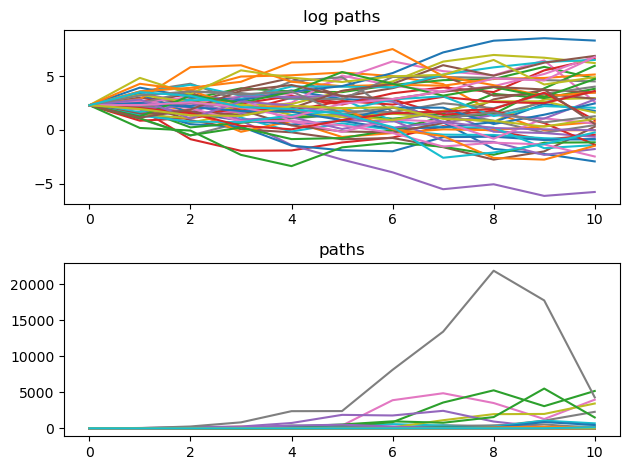

In [15]:
fig, axes = plt.subplots(2, 1)

titles = 'log paths', 'paths'
transforms = np.log, lambda x: x
for ax, transform, title in zip(axes, transforms, titles):
    for i in range(50):
        path = simulate_asset_price_path()
        ax.plot(transform(path))
    ax.set_title(title)

fig.tight_layout()
plt.show()

In [16]:
def compute_call_price(β=β,
                       μ=μ,
                       S0=S0,
                       h0=h0,
                       K=K,
                       n=n,
                       ρ=ρ,
                       ν=ν,
                       M=10_000):
    current_sum = 0.0
    # For each sample path
    for m in range(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)

    return β**n * current_sum / M

In [17]:
%%time
compute_call_price()

CPU times: user 298 ms, sys: 4.28 ms, total: 303 ms
Wall time: 106 ms


697.5414475240406

In [18]:
def compute_call_price(β=β,
                       μ=μ,
                       S0=S0,
                       h0=h0,
                       K=K,
                       n=n,
                       ρ=ρ,
                       ν=ν,
                       M=10_000):

    s = np.full(M, np.log(S0))
    h = np.full(M, h0)
    for t in range(n):
        Z = np.random.randn(2, M)
        s = s + μ + np.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = np.mean(np.maximum(np.exp(s) - K, 0))

    return β**n * expectation

In [19]:
%%time
compute_call_price()

CPU times: user 5.52 ms, sys: 119 µs, total: 5.64 ms
Wall time: 3.9 ms


629.8667102475052

In [20]:
%%time
compute_call_price(M=10_000_000)

CPU times: user 3.9 s, sys: 457 ms, total: 4.35 s
Wall time: 4.27 s


863.7308092195075

In [21]:
μ  = 0.0001
ρ  = 0.1
ν  = 0.001
S0 = 10
h0 = 0
K = 100
n = 10
β = 0.95
bp = 120

In [22]:
def compute_call_price_with_barrier(β=β,
                                    μ=μ,
                                    S0=S0,
                                    h0=h0,
                                    K=K,
                                    n=n,
                                    ρ=ρ,
                                    ν=ν,
                                    bp=bp,
                                    M=50_000):
    current_sum = 0.0
    # For each sample path
    for m in range(M):
        s = np.log(S0)
        h = h0
        payoff = 0
        option_is_null = False
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
            if np.exp(s) > bp:
                payoff = 0
                option_is_null = True
                break

        if not option_is_null:
            payoff = np.maximum(np.exp(s) - K, 0)
        # And add the payoff to current_sum
        current_sum += payoff

    return β**n * current_sum / M

In [23]:
%time compute_call_price_with_barrier()

CPU times: user 674 ms, sys: 1.14 ms, total: 675 ms
Wall time: 675 ms


0.038578134995685895

In [24]:
def compute_call_price_with_barrier_vector(β=β,
                                           μ=μ,
                                           S0=S0,
                                           h0=h0,
                                           K=K,
                                           n=n,
                                           ρ=ρ,
                                           ν=ν,
                                           bp=bp,
                                           M=50_000):
    s = np.full(M, np.log(S0))
    h = np.full(M, h0)
    option_is_null = np.full(M, False)
    for t in range(n):
        Z = np.random.randn(2, M)
        s = s + μ + np.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
        # Mark all the options null where S_n > barrier price
        option_is_null = np.where(np.exp(s) > bp, True, option_is_null)

    # mark payoff as 0 in the indices where options are null
    payoff = np.where(option_is_null, 0, np.maximum(np.exp(s) - K, 0))
    expectation = np.mean(payoff)
    return β**n * expectation

In [25]:
%time compute_call_price_with_barrier_vector()

CPU times: user 20.9 ms, sys: 691 µs, total: 21.6 ms
Wall time: 21.6 ms


0.03397926036183827